In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
import matplotlib.pyplot as plt
%matplotlib inline
from random import randint
from operator import itemgetter
from scipy.stats import randint as sp_randint
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

---
MNIST Grid Search
=====
***

###Firstly, let's define some utility functions

In [30]:
def grid_report(grid_scores, n_top=3):
    '''This function will report the best scores from grid search'''
    
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
def my_confusion_matrix(y_test, y_hat, names):
    '''This function uses the pd.crosstab function to create a confusion matrix:
    predictions are the predictions from the predictive mode
    y are the known class labels
    names are the names of the features used in the model'''
    
    cf = pd.crosstab(y_test, y_hat)
    cf.columns = names
    cf.index = names
    cf.columns.name = 'Prediction'
    cf.index.name = 'Actual'
    return cf
        
def reduce_dataset(mnist, M_of_each_class, N, n_classes):
    M = M_of_each_class
    X1 = np.zeros((M*n_classes, N))
    y1 = np.zeros((M*n_classes, 1))
    features = range(N)
    df1 = pd.DataFrame(mnist.data)
    df1["y"] = mnist.target
    for i in xrange(0, n_classes+1):
        j = i+1
        X1[i*M:j*M, :] = df1[df1.y == i][features][0:M].values
        y1[i*M:j*M, :] = i
    return (X1, y1)

def my_shuffle(X, y, data_set_size):
    Xa = X.copy()
    ya = y.copy()
    
    for i in xrange(1000000):
        n1 = randint(0, data_set_size-1)
        n2 = randint(0, data_set_size-1)
        
        tempx = Xa[n1, :].copy()
        tempy = ya[n1].copy()

        Xa[n1, :] = Xa[n2, :].copy()
        ya[n1] = ya[n2].copy()

        Xa[n2, :] = tempx
        ya[n2] = tempy
    
    return (Xa, ya)

##If you use grid search with loss functions, e.g. mean squared error, (regression) you must negate it. 

##Grid Search always tries to MAXMIMIZE it's score

---
#The MNIST Database
---
[MNIST Database](https://en.wikipedia.org/wiki/MNIST_database)

In [5]:
mnist = fetch_mldata('MNIST original')

####MNIST is 70000 samples of 784 dimensions and 10 classes

#####For now let's just use 100 samples!!

In [6]:
X1, y1 = reduce_dataset(mnist, 100, 784, 10)

#####The 784 dimensions represents a 28 by 28 grayscale image with values of [0..256]
#####Dividing by 256 scales the data nicely

In [7]:
X1 = X1/256.0

In [8]:
print len(X1)
print X1.shape
print y1.shape

1000
(1000, 784)
(1000, 1)


#####Having extracted equal class numbers, shuffle the data

In [9]:
X, y = my_shuffle(X1, y1, 1000)
y = y.ravel()
print X.shape
print y.shape

(1000, 784)
(1000,)


#####Let's check out some images

1.0 1.0 8.0 9.0 8.0 6.0 6.0 5.0 2.0 0.0 6.0 3.0


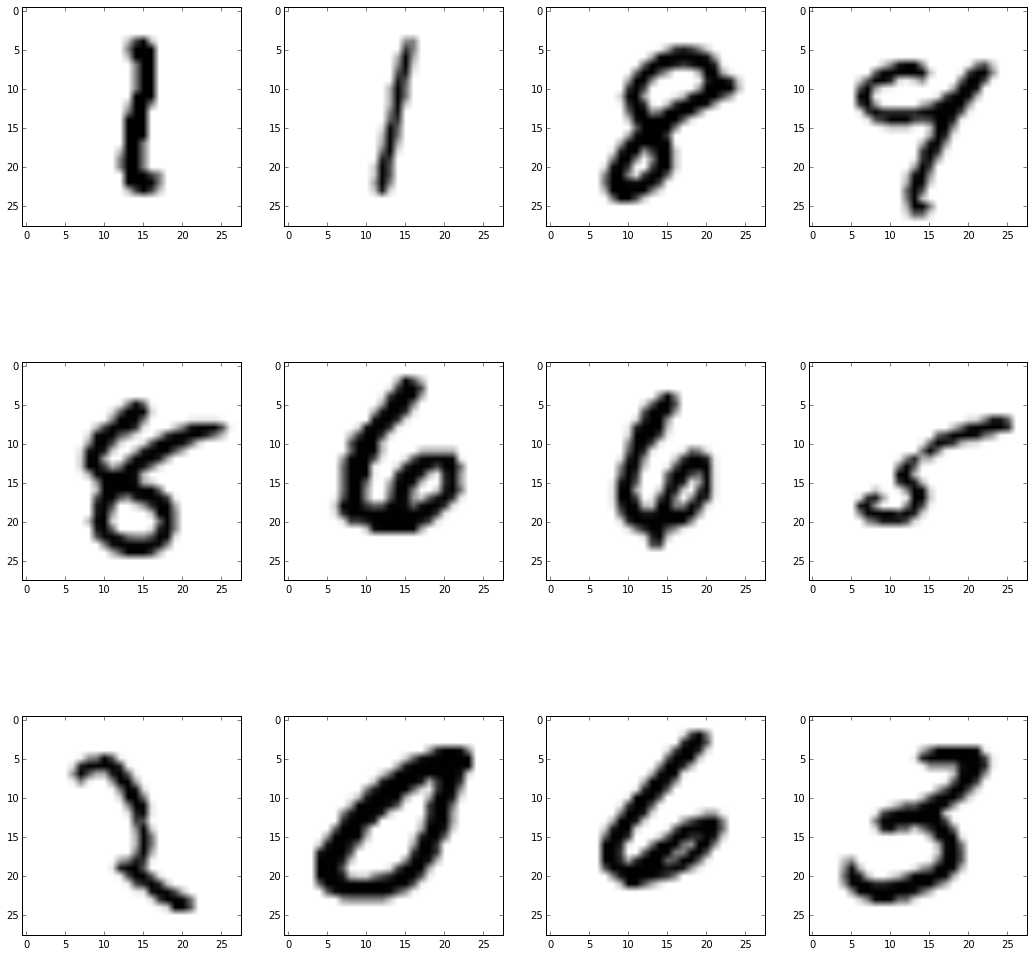

In [31]:
x_image = {}
for i in xrange(12):
    x_image[i] = np.array(X[i])
    x_image[i] = x_image[i].reshape(28, 28)

fig = plt.figure(figsize = (18, 18))

for i in xrange(12):
    ax = plt.subplot(3, 4, i+1)
    print y[i],
    ax.imshow(x_image[i], cmap='binary')
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)

---
Grid Search - Exhaustive
=====
***

##GridSearchCV may not work in an interactive interpreter
##It may work if n_jobs != -1, i.e. it may work in an unparallelized mode

##Grid Search is an exhaustive search over the hyper-parameters
##It also allows for the easy creation of training, x-validation and test sets!!

In [ ]:
#Type in this cell

####Extract all the results

In [33]:
print "{:5.3f}".format(myGS.best_score_)

0.648


In [34]:
best_parameters = myGS.best_estimator_.get_params()
for p in sorted(params.keys()):
    print "{:35s} {:25s}".format(p, str(best_parameters[p]))

max_depth                           150                      
min_samples_leaf                    1                        
min_samples_split                   3                        


In [35]:
y_hat = myGS.predict(X_test)
print "Accuracy: {:5.3f}".format(accuracy_score(y_test, y_hat))

Accuracy: 0.680


In [36]:
print classification_report(y_test, y_hat)

             precision    recall  f1-score   support

        0.0       0.84      0.91      0.87        23
        1.0       0.88      0.88      0.88        25
        2.0       0.65      0.71      0.68        24
        3.0       0.64      0.73      0.68        22
        4.0       0.50      0.63      0.56        19
        5.0       0.59      0.65      0.62        20
        6.0       0.75      0.36      0.49        33
        7.0       0.75      0.72      0.73        25
        8.0       0.60      0.70      0.65        30
        9.0       0.64      0.62      0.63        29

avg / total       0.69      0.68      0.67       250



In [37]:
names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
cm = my_confusion_matrix(y_test, y_hat, names)
print cm

Prediction   0   1   2   3   4   5   6   7   8   9
Actual                                            
0           21   0   0   0   1   0   0   0   1   0
1            0  22   0   2   0   0   0   0   0   1
2            0   0  17   1   1   1   0   0   3   1
3            1   1   1  16   0   2   0   0   1   0
4            0   0   2   0  12   2   0   1   2   0
5            1   0   0   3   0  13   0   0   1   2
6            2   0   3   1   6   1  12   1   5   2
7            0   1   2   0   1   0   1  18   0   2
8            0   1   1   2   0   2   1   0  21   2
9            0   0   0   0   3   1   2   4   1  18


####It is easy to set exhaustive grid search into a almost infinite loop
####A 'better' function to use is Randomized Grid Search

---
Randomized Grid Search
=====
***

In [1]:
#Type in this cell

####Check out the results

In [39]:
print "{:5.3f}".format(myRGS.best_score_)

0.652


In [40]:
best_parameters = myRGS.best_estimator_.get_params()
for p in sorted(params.keys()):
    print "{:35s} {:25s}".format(p, str(best_parameters[p]))

max_depth                           166                      
min_samples_leaf                    3                        
min_samples_split                   7                        


In [41]:
y_hat = myRGS.predict(X_test)
print "Accuracy: {:5.3f}".format(accuracy_score(y_test, y_hat))

Accuracy: 0.648


In [42]:
print classification_report(y_test, y_hat)

             precision    recall  f1-score   support

        0.0       0.90      0.83      0.86        23
        1.0       0.76      0.76      0.76        25
        2.0       0.87      0.57      0.68        23
        3.0       0.50      0.39      0.44        28
        4.0       0.47      0.75      0.58        20
        5.0       0.59      0.63      0.61        27
        6.0       0.71      0.65      0.68        26
        7.0       0.62      0.82      0.71        22
        8.0       0.59      0.62      0.60        21
        9.0       0.65      0.57      0.61        35

avg / total       0.66      0.65      0.65       250



In [43]:
names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
cm = my_confusion_matrix(y_test, y_hat, names)
print cm

Prediction   0   1   2   3   4   5   6   7   8   9
Actual                                            
0           19   0   0   1   0   0   1   1   1   0
1            0  19   1   0   0   2   1   0   2   0
2            0   0  13   1   2   0   2   3   2   0
3            0   2   0  11   1   7   0   2   1   4
4            0   0   0   0  15   1   1   1   0   2
5            0   0   0   2   4  17   0   1   1   2
6            2   1   0   2   0   1  17   2   0   1
7            0   0   0   0   2   0   0  18   1   1
8            0   3   1   1   0   0   1   1  13   1
9            0   0   0   4   8   1   1   0   1  20


In [45]:
report(myRGS.grid_scores_)

Model with rank: 1
Mean validation score: 0.652 (std: 0.012)
Parameters: {'min_samples_split': 7, 'max_depth': 166, 'min_samples_leaf': 3}

Model with rank: 2
Mean validation score: 0.651 (std: 0.021)
Parameters: {'min_samples_split': 3, 'max_depth': 165, 'min_samples_leaf': 2}

Model with rank: 3
Mean validation score: 0.648 (std: 0.035)
Parameters: {'min_samples_split': 5, 'max_depth': 156, 'min_samples_leaf': 1}



#Set up a new cell and random grid search using an ensemble method
#Start slowly increasing the number of vectors in the data set